In [1]:
import pickle
import pandas as pd
import numpy as np
import astropy.units as u
from astropy import constants
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
field_size= 1.4**2 * u.deg**2
cat = pickle.load(open("OUTPUTS/pySIDES_from_original.p", "rb"))

In [3]:
freq_bins = 10.**np.arange(np.log10(20),np.log10(2000),0.02)

freq = 0.5*(freq_bins[0:-1]+freq_bins[1:])

line_list = []
for k in range(1,9):
    line_list.append('CO{:0.0f}{:0.0f}'.format(k, k-1))
rest_freq_list = list(np.arange(1,9)*115.27)

line_list += ['CI10', 'CI21', 'CII_de_Looze', 'CII_Lagache']
rest_freq_list += [492.16, 809.34, 1900.54, 1900.54]

line_background_MJy_sr = np.zeros((len(freq),len(line_list)))

delta_v_bin = np.diff(freq_bins) / freq * constants.c.to('km/s')

for k, rest_freq, line in zip(range(0, len(line_list)), rest_freq_list, line_list):
    freq_line = rest_freq / (1. + cat['redshift'])
    histo, bins = np.histogram(freq_line, bins = freq_bins, weights = cat['I'+line])
    line_background_MJy_sr[:,k] = histo / delta_v_bin

line_background_MJy_sr = np.array(line_background_MJy_sr * 1.e-6 / field_size.to('sr'))

In [4]:
#polynome fort the high SFRD model
pcorr = np.poly1d([ 1.32063242e-02, -3.44720436e-01,  3.21803207e+00, -1.31490389e+01, 19.788931271994528])

In [5]:
CO_bkg = np.sum(line_background_MJy_sr[:,0:8], axis = 1)

In [6]:
CI_bkg = np.sum(line_background_MJy_sr[:,8:10], axis = 1)

In [7]:
Yue20 = np.loadtxt('/Users/mbethermin/SIDES/POWSPEC/Yue2020/fig12.txt', skiprows = 1)
Yang21 = np.loadtxt('Yang2021_avgI_SAM.txt')

In [8]:
#compute the continuum background from the Generic cube
hdu = fits.open('pySIDES_from_original_0_3000GHz_continuum_nobeam_MJy_sr.fits')
hdr = hdu[0].header
np.shape(hdu[0].data)
freq_cont = 1.e-9 * ((np.arange(0, hdr['NAXIS3']+1) - 0.5 -(hdr['CRPIX3']-1)) \
                  * hdr['CDELT3']-1 + hdr['CRVAL3'])
Bnu_cont = np.mean(hdu[0].data, axis = (1,2)) #MJy/sr

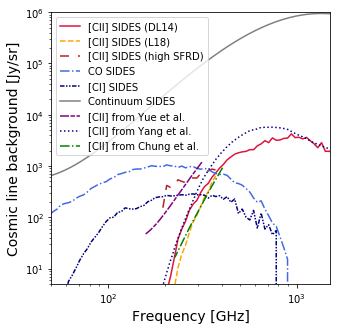

In [9]:
#Nice paper plot to compare the [CII] intensity with other models

label = ['[CII] SIDES (DL14)', '[CII] SIDES (L18)', '[CII] SIDES (high SFRD)']
color = ['crimson', 'orange', 'firebrick']
linestyle = ['-', '--', (0, (6, 6))]
freq_range = np.array([[0,1.e10], [0,380], [190,380]])
k_list=[10,11,10]

plt.figure(figsize = (5,5))

for k in range(0,len(label)):
    
    sel = np.where((freq > freq_range[k,0]) & (freq < freq_range[k,1]))
    if k == 2:
        corr = 10.**(-1.*pcorr(1900/freq[sel[0]]-1.))
    else:
        corr = 1. 
             
    plt.plot(freq[sel[0]], 1.e6 * corr * line_background_MJy_sr[sel[0],k_list[k]], 'k', zorder = 1,
             label = label[k], color = color[k], linestyle = linestyle[k])
         
plt.plot(freq, 1.e6*CO_bkg, '-.', color = 'royalblue', label = 'CO SIDES')
plt.plot(freq, 1.e6*CI_bkg, color = 'navy', linestyle = (0, (3, 1, 1, 1, 1, 1)), label = '[CI] SIDES')

plt.plot(freq_cont[0:-1], 1.e6*Bnu_cont, color = 'grey', label = 'Continuum SIDES')
    
plt.plot(Yue20[:,0], Yue20[:,1], label = '[CII] from Yue et al.', color = 'purple', linestyle = (0, (6,1,3,1)))

plt.plot(1900.54 / (1+Yang21[:,0]), Yang21[:,1], label = '[CII] from Yang et al.', color = 'navy', linestyle = ':')

plt.errorbar(1900 / (1.+np.array([3.7, 4.5, 6., 7.4])), [924.2, 339.2, 64.75, 16.58], linestyle = '-.', color = 'green', label = '[CII] from Chung et al.')
#yerr = [[35.1, 14.5, 3.08,0.66],[54.1, 9.7, 2.33,0.69]]    

plt.xlim([50., 1500.])
plt.xscale('log')
plt.ylim([5.,1.e6])
plt.yscale('log')
plt.xlabel('Frequency [GHz]', size = 14) 
plt.ylabel('Cosmic line background [Jy/sr]', size = 14)
plt.legend()

plt.savefig('CII_line_background.pdf', dpi = 150)

In [10]:
np.shape(line_background_MJy_sr)

(99, 12)

In [11]:
line_list

['CO10',
 'CO21',
 'CO32',
 'CO43',
 'CO54',
 'CO65',
 'CO76',
 'CO87',
 'CI10',
 'CI21',
 'CII_de_Looze',
 'CII_Lagache']

Intersection CO/CII background (DL14)=  370.5382365683566
Intersection CO/CII background (high SFRD)=  346.11268076743147
Intersection CO/CII background (L18)=  377.8956257587241


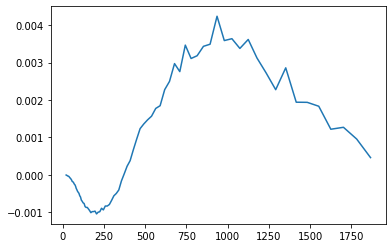

In [12]:
plt.plot(freq, line_background_MJy_sr[:,10] - CO_bkg)
print('Intersection CO/CII background (DL14)= ', np.interp(0, line_background_MJy_sr[:,10] - CO_bkg, freq))
print('Intersection CO/CII background (high SFRD)= ',np.interp(0, corr*line_background_MJy_sr[sel[0],10] - CO_bkg[sel[0]], freq[sel[0]]))
print('Intersection CO/CII background (L18)= ',np.interp(0, line_background_MJy_sr[:,11] - CO_bkg, freq))

